# 🧠 The Monty Hall Problem

The Monty Hall problem is a classic puzzle in probability theory that challenges
our intuition about conditional probability.

You are on a game show with **three doors**:

- Behind one door is a **car**
- Behind the other two are **goats**

#### The rules
1. You choose one door.
2. The host, who knows where the car is, opens **one of the remaining doors**,
   always revealing a goat.
3. You are given the option to **stay** with your original choice or **switch**
   to the remaining unopened door.

The question is simple:

> **Should you switch?**

### 🤔 Naive Intuition

After the host opens a door, two doors remain.
It feels natural to assume that the probability of winning is now 50–50.

This intuition is compelling — and wrong.

To understand why, we will:
1. Formalize the rules of the game
2. Simulate the process step by step
3. Compare strategies using computation

## The Mathematical Proof (Bayes' Theorem)

Intuition suggests the odds are 50/50 because two doors remain. However, the host's action adds **information** to the system. Let's prove why switching works using Bayes' Theorem.

Let:
* $C_i$: The Car is behind Door $i$ (for $i \in \{1, 2, 3\}$).
* $X_1$: The Player picks Door 1.
* $H_3$: The Host opens Door 3.

We want to find the probability that the car is behind Door 2 given the host opened Door 3: **$P(C_2 | H_3, X_1)$**.
 
Using Bayes' Theorem:
$$ P(C_2 | H_3, X_1) = \frac{P(H_3 | C_2, X_1) \cdot P(C_2)}{P(H_3 | X_1)} $$

**Step 1: The Priors**
The car is equally likely to be behind any door.
$$ P(C_1) = P(C_2) = P(C_3) = \frac{1}{3} $$

**Step 2: The Likelihoods (The Host's Constraints)**
* If the car is behind Door 2 ($C_2$), and we picked Door 1, the host **must** open Door 3 (he can't open Door 1, and he can't reveal the car at Door 2).
$$ P(H_3 | C_2, X_1) = 1 $$
* If the car is behind Door 1 ($C_1$), the host can open either Door 2 or Door 3 randomly.
$$ P(H_3 | C_1, X_1) = \frac{1}{2} $$

**Step 3: The Total Probability (Denominator)**
$$ P(H_3 | X_1) = P(H_3 | C_1)P(C_1) + P(H_3 | C_2)P(C_2) + P(H_3 | C_3)P(C_3) $$
$$ P(H_3 | X_1) = (\frac{1}{2} \cdot \frac{1}{3}) + (1 \cdot \frac{1}{3}) + (0 \cdot \frac{1}{3}) = \frac{1}{6} + \frac{1}{3} = \frac{1}{2} $$

**Step 4: The Result**
$$ P(C_2 | H_3, X_1) = \frac{1 \cdot (1/3)}{1/2} = \frac{2}{3} $$

**Conclusion:** The probability of winning if you switch to Door 2 is **2/3**, while staying at Door 1 is only **1/3**.


## The Computational Experiment
We will now build a Python class to simulate this game several (about 10,000) times to verify our math.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MontyHall:
    """
    A simulator for the Monty Hall problem.
    
    The 'game' consists of 3 doors:
    [0] [1] [2]
    
    One hides a prize (Car), two hide duds (Goats).
    """
    
    def __init__(self, num_doors=3):
        """
        Initialize the game settings.
        
        Args:
            num_doors (int): Standard game uses 3, but logic holds for N > 3.
        """
        if num_doors < 3:
            raise ValueError("Standard Monty Hall requires at least 3 doors.")
        self.num_doors = num_doors

    def run_single_episode(self, switch: bool) -> bool:
        """
        Simulates a single round of the game.

        Logic Flow:
        1. Place Car:       [G] [C] [G]  (Random hidden state)
        2. Player Picks:    ^ Pick 0
        3. Host Opens:              ^ Opens 2 (Must be G, not Player's pick)
        4. Switch/Stay:         ^ Result depends on strategy
        
        Args:
            switch (bool): 
                True  -> Player switches to the remaining closed door.
                False -> Player stays with their original choice.
                           
        Returns:
            bool: True if final choice is the Car.
        """
        # --- PHASE 1: SETUP ---
        doors = list(range(self.num_doors))
        car_position = random.choice(doors)
        player_choice = random.choice(doors)
        
        # --- PHASE 2: THE REVEAL ---
        # The host must open a door that is:
        # 1. NOT the car (cannot ruin the game)
        # 2. NOT the player's choice (cannot force a loss immediately)
        available_for_host = [
            d for d in doors 
            if d != car_position and d != player_choice
        ]
        host_opens = random.choice(available_for_host)
        
        # --- PHASE 3: THE DECISION ---
        if switch:
            # Player switches to the only other door left closed.
            # In a 3-door game: Total(3) - Player(1) - Host(1) = 1 door left.
            remaining_doors = [
                d for d in doors 
                if d != player_choice and d != host_opens
            ]
            final_choice = remaining_doors[0]
        else:
            final_choice = player_choice
            
        return final_choice == car_position

    def run_simulation(self, trials=1000):
        """
        Runs the simulation 'trials' times for BOTH strategies independenty.
        
        Returns:
            dict: {'stay_wins': int, 'switch_wins': int}
        """
        results = {'stay_wins': 0, 'switch_wins': 0}
        
        # Run batch for 'Stay' Strategy
        for _ in range(trials):
            if self.run_single_episode(switch=False):
                results['stay_wins'] += 1
                
        # Run batch for 'Switch' Strategy
        for _ in range(trials):
            if self.run_single_episode(switch=True):
                results['switch_wins'] += 1
                
        return results
        
    def plot_results(self, results, trials):
        """
        Generates a clean bar chart comparison of the strategies.
        """
        strategies = ['Stay', 'Switch']
        counts = [results['stay_wins'], results['switch_wins']]
        probs = [c / trials for c in counts]
        
        plt.figure(figsize=(10, 6))
        
        # Plot Bars
        bars = plt.bar(strategies, probs, color=['#e74c3c', '#2ecc71'], 
                      alpha=0.9, edgecolor='#2c3e50', linewidth=1.5)
        
        # Theoretical Reference Lines
        plt.axhline(y=1/3, color='#c0392b', linestyle='--', linewidth=2, label='Theory (Stay): 33.3%')
        plt.axhline(y=2/3, color='#27ae60', linestyle='--', linewidth=2, label='Theory (Switch): 66.7%')
        
        # Styling
        plt.ylim(0, 1)
        plt.ylabel('Win Probability', fontsize=12)
        plt.title(f'Simulation Results (N={trials:,} games)', fontsize=14, fontweight='bold')
        plt.legend(loc='upper left', frameon=True)
        plt.grid(axis='y', linestyle=':', alpha=0.6)
        
        # Annotate bars with percentages
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.1%}',
                     ha='center', va='bottom', fontsize=12, fontweight='bold', color='#2c3e50')
        
        plt.show()

In [3]:
# %% Execution Script

# 1. Configuration
NUM_TRIALS = 10_000
print(f"Running Monte Carlo Simulation with {NUM_TRIALS:,} trials...")

# 2. Initialization
game = MontyHall(num_doors=3)

# 3. Processing
results = game.run_simulation(trials=NUM_TRIALS)

# 4. Text Report
print("\n--- Final Results ---")
print(f"Stay Strategy Wins:   {results['stay_wins']} ({results['stay_wins']/NUM_TRIALS:.1%})")
print(f"Switch Strategy Wins: {results['switch_wins']} ({results['switch_wins']/NUM_TRIALS:.1%})")


Running Monte Carlo Simulation with 10,000 trials...

--- Final Results ---
Stay Strategy Wins:   3388 (33.9%)
Switch Strategy Wins: 6702 (67.0%)


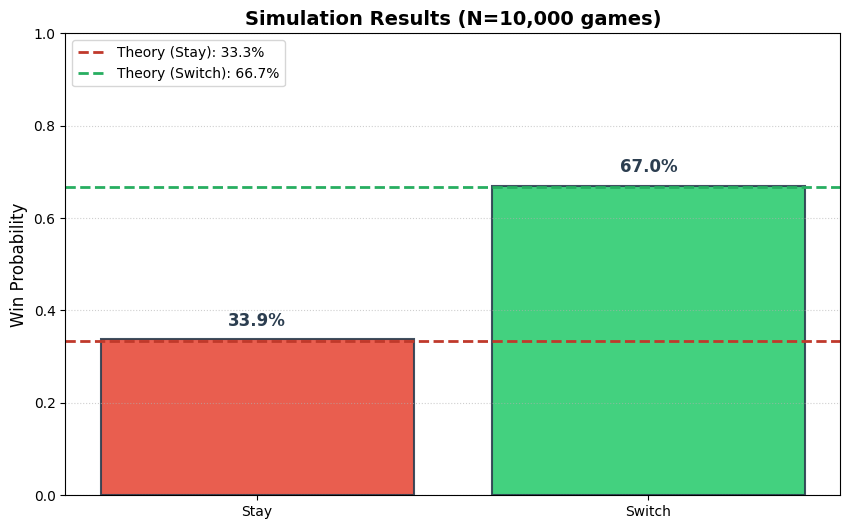

In [4]:
# %% Visualization
game.plot_results(results, NUM_TRIALS)

### Takeaway

* The Monty Hall problem is not paradoxical.
Our intuition fails because we ignore conditional information.
* By explicitly modeling the rules of the game, the correct behavior becomes unavoidable.

## The Monty Hall Paradox: Generalizing to N Doors

### The Scenario
1. **Setup**: $N$ doors. 1 Car, $N-1$ Goats.
2. **Choice**: You pick 1 door.
3. **Reveal**: The host opens $k$ doors (revealing goats).
4. **Decision**: You switch to one of the remaining closed doors.

### The Generalized Math
Why does switching work? It relies on the concentration of probability.
* **P(Initial Pick Correct):** $1/N$
* **P(Car is in the other group):** $(N-1)/N$

When the host opens $k$ doors from the "other group", he tells you they are empty. The entire $(N-1)/N$ probability mass shifts to the remaining closed doors in that group.


In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
import sympy
from sympy import symbols, simplify, init_printing

# Configure sympy for pretty printing in Jupyter
init_printing(use_latex='mathjax')

### Deriving the General Formula with SymPy
Before running the simulation, let's derive the exact probability formula symbolically.

In [6]:
def derive_monty_hall_formula():
    """
    Derives the probability of winning by switching using symbolic math.
    """
    # Define symbols
    N = symbols('N', integer=True, positive=True, description="Total Doors")
    k = symbols('k', integer=True, positive=True, description="Doors Opened by Host")
    
    print("--- Symbolic Derivation ---")
    
    # 1. Probability of staying (Winning implies original pick was correct)
    P_stay = 1 / N
    print(f"1. Probability you picked correctly initially (Stay wins):")
    display(P_stay)
    
    # 2. Probability original pick was WRONG (Car is in the 'other' set)
    P_initial_wrong = (N - 1) / N
    print(f"2. Probability you picked WRONG (Car is in the 'Other Group'):")
    display(P_initial_wrong)
    
    # 3. Number of doors remaining in the 'other' set
    # Originally N-1 doors. Host removes k of them.
    remaining_doors = (N - 1) - k
    print(f"3. Doors remaining in 'Other Group' after host opens k doors:")
    display(remaining_doors)
    
    # 4. Probability of switching (Winning implies original pick was wrong)
    # The probability mass of the 'other' set concentrates on the remaining doors.
    print(f"4. Probability of Switch Winning:")
    print("   (Total Prob of Other Group) / (Remaining Doors in Other Group)")
    P_switch = P_initial_wrong * (1 / remaining_doors)
    display(P_switch)

    # Simplify the expression
    P_switch_simplified = simplify(P_switch)
    
    print(f"5. Simplified General Formula:")
    display(P_switch_simplified)
    
    return P_switch_simplified

# Execute the derivation
general_formula = derive_monty_hall_formula()

--- Symbolic Derivation ---
1. Probability you picked correctly initially (Stay wins):


1
─
N

2. Probability you picked WRONG (Car is in the 'Other Group'):


N - 1
─────
  N  

3. Doors remaining in 'Other Group' after host opens k doors:


N - k - 1

4. Probability of Switch Winning:
   (Total Prob of Other Group) / (Remaining Doors in Other Group)


    N - 1    
─────────────
N⋅(N - k - 1)

5. Simplified General Formula:


    1 - N     
──────────────
N⋅(-N + k + 1)

### Interpretation
For the standard game ($N=3, k=1$), the formula becomes:
$$ \frac{3-1}{3(3-1-1)} = \frac{2}{3(1)} = \frac{2}{3} $$

For the 100-door game where host opens 98 ($N=100, k=98$):
$$ \frac{99}{100(100-1-98)} = \frac{99}{100(1)} = \frac{99}{100} $$

In [7]:
class GeneralizedMontyHall:
    """
    A generalized simulator for the Monty Hall problem allowing N doors.
    """
    
    def __init__(self, num_doors=3, num_to_open=None):
        """
        Initialize the game settings.
        
        Args:
            num_doors (int): Total number of doors.
            num_to_open (int): How many goats the host reveals. 
                               Defaults to (num_doors - 2), leaving just 1 alternative.
        """
        if num_doors < 3:
            raise ValueError("Simulation requires at least 3 doors.")
            
        self.num_doors = num_doors
        
        # Default behavior: Host opens all doors except player's pick and one other.
        if num_to_open is None:
            self.num_to_open = num_doors - 2
        else:
            self.num_to_open = num_to_open
            
        # Validation
        if self.num_to_open >= num_doors - 1:
            raise ValueError("Host cannot open all remaining doors (must leave one closed).")

    def run_single_episode(self, switch: bool) -> bool:
        """
        Simulates a single round.
        
        Logic Flow:
        1. Place Car:       [0..N-1]
        2. Player Picks:    [Random]
        3. Host Opens:      [k] Goats from the unchosen set
        4. Switch/Stay:     Resolve winner
        """
        # --- PHASE 1: SETUP ---
        doors = list(range(self.num_doors))
        car_position = random.choice(doors)
        player_choice = random.choice(doors)
        
        # --- PHASE 2: THE REVEAL ---
        # Host identifies strict goats (excluding player pick and car)
        can_open = [d for d in doors if d != car_position and d != player_choice]
        
        # Host randomly picks 'num_to_open' doors from available goats
        host_opens = random.sample(can_open, self.num_to_open)
        
        # --- PHASE 3: THE DECISION ---
        if switch:
            # Identify valid switch targets (Closed doors that are NOT player's current pick)
            switch_options = [
                d for d in doors 
                if d not in host_opens and d != player_choice
            ]
            
            # Player picks one random door from the remaining options
            final_choice = random.choice(switch_options)
        else:
            final_choice = player_choice
            
        return final_choice == car_position

    def run_simulation(self, trials=1000):
        """
        Runs the simulation 'trials' times for BOTH strategies.
        """
        results = {'stay_wins': 0, 'switch_wins': 0}
        
        for _ in range(trials):
            if self.run_single_episode(switch=False):
                results['stay_wins'] += 1
        
        for _ in range(trials):
            if self.run_single_episode(switch=True):
                results['switch_wins'] += 1
                
        return results

    def print_results(self, results, trials):
        """
        Prints the simulation statistics to the console, comparing with analytical theory.
        """
        # Calculate Analytical Probabilities
        N = self.num_doors
        k = self.num_to_open
        remaining_alternatives = (N - 1) - k
        
        prob_stay = 1.0 / N
        prob_switch = ((N - 1) / N) * (1.0 / remaining_alternatives)

        print(f"\n--- Final Results (N={trials:,}) ---")
        print(f"Stay Strategy Wins:   {results['stay_wins']} ({results['stay_wins']/trials:.1%}) | Theory: {prob_stay:.1%}")
        print(f"Switch Strategy Wins: {results['switch_wins']} ({results['switch_wins']/trials:.1%}) | Theory: {prob_switch:.1%}")
        
    def plot_results(self, results, trials, ax=None, bar_position=None, width=0.8, label_prefix="", alpha=0.9):
        """
        Visualizes the outcome against analytical predictions.
        
        Args:
            results (dict): Results from run_simulation.
            trials (int): Number of trials run.
            ax (matplotlib.axes.Axes, optional): The subplot to draw on.
            bar_position (float, optional): Offset for bar position (for grouped plots).
            width (float): Width of bars.
            label_prefix (str): Prefix for legend labels (e.g., 'Classic').
            alpha (float): Transparency level for the bars (0.0 to 1.0).
        """
        # Calculate Analytical Probabilities
        N = self.num_doors
        k = self.num_to_open
        remaining_alternatives = (N - 1) - k
        
        prob_stay = 1.0 / N
        prob_switch = ((N - 1) / N) * (1.0 / remaining_alternatives)
        
        # Empirical Data
        strategies = ['Stay', 'Switch']
        counts = [results['stay_wins'], results['switch_wins']]
        probs = [c / trials for c in counts]
        
        # Setup Plot Area
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
            show_after = True
        else:
            show_after = False

        # Determine Bar Positions (standard or grouped)
        if bar_position is None:
            # Standard string-based positioning
            x_coords = strategies
        else:
            # Numeric positioning for offsets
            x_coords = np.arange(len(strategies)) + bar_position

        # Plotting
        bars = ax.bar(x_coords, probs, width=width, color=['#3498db', '#e67e22'], 
                      alpha=alpha, edgecolor='#2c3e50', label=label_prefix)
        
        # Theoretical Lines
        # We only add labels to the lines if it's the first plot (bar_position is None or 0) 
        # to avoid duplicating legend entries in grouped charts.
        show_theory_label = (bar_position is None or abs(bar_position) < 0.1)
        
        label_stay = f'Theory (Stay): {prob_stay:.1%}' if show_theory_label else None
        label_switch = f'Theory (Switch): {prob_switch:.1%}' if show_theory_label else None

        ax.axhline(y=prob_stay, color='#2980b9', linestyle='--', linewidth=2, 
                    alpha=alpha, label=label_stay)
        ax.axhline(y=prob_switch, color='#d35400', linestyle='--', linewidth=2, 
                    alpha=alpha, label=label_switch)
        
        # Styling
        if bar_position is not None:
            # Reset ticks to center if using numeric offsets
            ax.set_xticks(np.arange(len(strategies)))
            ax.set_xticklabels(strategies)

        ax.set_ylim(0, 1.05) 
        ax.set_ylabel('Win Probability')
        # Only set title if it's a single plot, otherwise let caller handle it
        if show_after:
            ax.set_title(f'Monty Hall: {N} Doors, Host Opens {k}\n(N={trials:,} games)')

        ax.legend()
        ax.grid(axis='y', linestyle=':', alpha=0.5)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        if show_after:
            plt.show()

In [8]:
# --- SIMULATION COMPARISON ---
print("Running Simulations for Comparison...")

NUM_TRIALS = 10_000
print(f"Running Monte Carlo Simulation with {NUM_TRIALS:,} trials...")

# 1. Run Classic (N=3)
classic_game = GeneralizedMontyHall(num_doors=3)
classic_results = classic_game.run_simulation(NUM_TRIALS)
classic_game.print_results(classic_results, NUM_TRIALS)

# 2. Run Massive
N_massive = 20
massive_game = GeneralizedMontyHall(num_doors=N_massive, num_to_open=N_massive-2)
massive_results = massive_game.run_simulation(NUM_TRIALS)
massive_game.print_results(massive_results, NUM_TRIALS)

Running Simulations for Comparison...
Running Monte Carlo Simulation with 10,000 trials...

--- Final Results (N=10,000) ---
Stay Strategy Wins:   3258 (32.6%) | Theory: 33.3%
Switch Strategy Wins: 6709 (67.1%) | Theory: 66.7%

--- Final Results (N=10,000) ---
Stay Strategy Wins:   475 (4.8%) | Theory: 5.0%
Switch Strategy Wins: 9495 (95.0%) | Theory: 95.0%


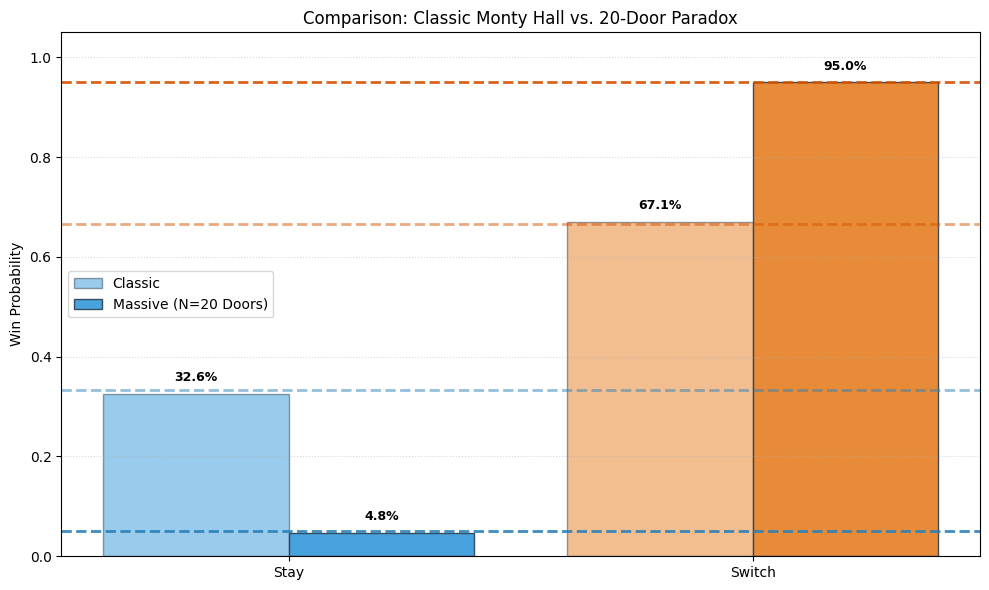

In [9]:
# Visualization: Grouped Bar Chart in Same Panel
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Classic (Shifted Left)
classic_game.plot_results(classic_results, NUM_TRIALS, ax=ax, alpha=0.5, 
                          bar_position=-0.2, width=0.4, label_prefix="Classic")

# Plot Massive (Shifted Right)
massive_game.plot_results(massive_results, NUM_TRIALS, ax=ax, alpha=0.9, 
                          bar_position=0.2, width=0.4, label_prefix=rf"Massive (N={N_massive} Doors)")

ax.set_title(rf"Comparison: Classic Monty Hall vs. {N_massive}-Door Paradox")
plt.tight_layout()
plt.show()